# Hamilton Barrage Comments Analyze

In [161]:
import requests, re, time, csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from wordcloud import WordCloud, STOPWORDS
import jieba 
# "Jieba" (Chinese for "to stutter") Chinese text segmentation: built to be the best Python Chinese word segmentation module.
 

In [181]:
table = pd.read_csv('data/danmu.csv',header=None)

table.head()

0  1   2         3                         4  5         6  \
P2 0  00:07:33  1  25  16777215  Tue Oct  3 11:57:28 2017  0  74f5f189   
   1  01:03:09  5  25   3342591  Tue Oct  3 22:00:07 2017  0  330f8e54   
   2  00:00:07  1  25  16777215  Thu Oct  5 23:53:42 2017  0  61309383   
   3  00:43:01  1  25  16777215  Fri Oct  6 06:35:04 2017  0  91b0ac3c   
   4  01:05:11  1  25  16777215  Fri Oct  6 06:53:48 2017  0  91b0ac3c   

               7                   8  
P2 0  3858893191              超爱的一首！  
   1  3859964859                 我蓝受  
   2  3868304125               承包林聚聚  
   3  3869845424  承包Leslie，长得又帅唱歌又好听  
   4  3869919013           承包 Leslie

In [182]:
# Reference：https://zhidao.baidu.com/question/1430448163912263499.html

# describe the table info:

# <d p="0,1,25,16777215,1312863760,0,eff85771,42759017">前排占位置</d>
# p这个字段里面的内容：
# 0,1,25,16777215,1312863760,0,eff85771,42759017 中几个逗号分割的数据
# col1:第一个参数是弹幕出现的时间 以秒数为单位。
# col2:第二个参数是弹幕的模式1..3 滚动弹幕 4底端弹幕 5顶端弹幕 6.逆向弹幕 7精准定位 8高级弹幕
# col3:第三个参数是字号， 12非常小,16特小,18小,25中,36大,45很大,64特别大
# col4:第四个参数是字体的颜色 以HTML颜色的十进制为准
# col5:第五个参数是Unix格式的时间戳。基准时间为 1970-1-1 08:00:00
# col6:第六个参数是弹幕池 0普通池 1字幕池 2特殊池 【目前特殊池为高级弹幕专用】
# col7:第七个参数是发送者的ID，用于“屏蔽此弹幕的发送者”功能
# col8:第八个参数是弹幕在弹幕数据库中rowID 用于“历史弹幕”功能。 

# 作者：X_xxieRiemann
# 链接：https://www.jianshu.com/p/b0991cbc23a4
# 来源：简书
# 简书著作权归作者所有，任何形式的转载都请联系作者获得授权并注明出处。


In [185]:
# Change the table name according to the describtion
table.columns = ['Time','Type','Font','Font Color','Date','Pool','UID','Row ID', 'Comment']

# sort table by  time in the video
table = table.sort_values(by=['Time'])

# table['Time']= pd.to_datetime(table['Time'])
# table['Date']= pd.to_datetime(table['Date'])
# table['Comment'] = table['Comment'].astype('str') 
print(len(table))
table.head()

6830


Time Type Font Font Color                      Date Pool  \
P2 1679  00:00:00    1   25   16777215  Thu Jun 21 00:53:15 2018    0   
   3380  00:00:00    1   25   16777215  Tue Mar  5 16:14:22 2019    0   
   2089  00:00:02    1   25   16777215  Fri Aug 10 11:21:03 2018    0   
   262   00:00:02    1   25   16777215  Fri Dec  1 15:45:09 2017    0   
   2059  00:00:03    5   25   16646914  Thu Aug  9 16:40:20 2018    0   

              UID             Row ID                Comment  
P2 1679  3cf1ddda   1271618705817600       无论何时打开，永远有人在看系列~  
   3380  14389b0f  12944192447184898                     +1  
   2089  bd7e321c   3556291943858180           这不是那个多角度剪辑版啊  
   262   3080457b         4006176668                    en>  
   2059   3d02a08   3521037123190788  av12767609 林聚聚的DEMO合集

## Analyze the comments for the Song You'll Be Back 

In [19]:
# Slice song [You'll Be Back] from 00:19:46-00:23:40 (about 4 mins)
youll_be_back = table.loc[(table['Time'] >= "00:19:46") & (table['Time'] <= "00:23:40"), :]
len(youll_be_back) # 492 

# count who comment the most in this song
a1 = youll_be_back[youll_be_back['UID'] == 'ee8d831e'] 
a2 = youll_be_back[youll_be_back['UID'] == '3cf1ddda']
a3 = youll_be_back[youll_be_back['UID'] == '3af77152']

a1

Time Type Font Font Color                      Date Pool  \
P2 3426  00:19:55    1   25   16777215  Thu Mar 14 08:19:35 2019    0   
   3448  00:21:08    1   25   16777215  Sun Mar 17 21:32:36 2019    0   
   3449  00:21:48    1   25   16777215  Sun Mar 17 21:33:22 2019    0   
P3 2536  00:21:53    1   25   16777215  Wed Mar 13 23:25:22 2019    0   
P2 3427  00:22:11    1   25   16777215  Thu Mar 14 08:21:59 2019    0   
P3 2535  00:22:22    1   25   16777215  Wed Mar 13 23:25:57 2019    0   
P2 3428  00:22:24    1   25   16777215  Thu Mar 14 08:22:29 2019    0   
   3450  00:23:27    1   25   16777215  Sun Mar 17 21:35:22 2019    0   

              UID             Row ID         Comment  
P2 3426  ee8d831e  13335055743582210    小乔人气好高啊哈哈哈哈哈  
   3448  ee8d831e  13495897355714560            可爱死了  
   3449  ee8d831e  13495921579393028        哇发脾气也可爱炸  
P3 2536  ee8d831e  13318250688413696        这么跳气都不乱啊  
P2 3427  ee8d831e  13335131501625346        镜头吓退2333  
P3 2535  ee8d831e  13318268922101762          还有杂技表演  
P2 3428  ee8d831e  13335146928275460  配音演员比动画好看23333  
   3450  ee8d831e  13495984435757060       全场妈妈粉正在激动

In [45]:
count = youll_be_back['UID'].value_counts()
top_15 = count.head(15).reset_index()
top_15 = top_15.rename(columns = {top_15.columns[0]:"UID",top_15.columns[1]:"Count"})
top_15

def Barrage(ID):
    result = youll_be_back[youll_be_back['UID'] == ID]
    return result


top_15['UID'].apply(Barrage)[0]
# for x in t:
#     if t in 

# t['Barrage']

Time Type Font Font Color                      Date Pool  \
P2 3426  00:19:55    1   25   16777215  Thu Mar 14 08:19:35 2019    0   
   3448  00:21:08    1   25   16777215  Sun Mar 17 21:32:36 2019    0   
   3449  00:21:48    1   25   16777215  Sun Mar 17 21:33:22 2019    0   
P3 2536  00:21:53    1   25   16777215  Wed Mar 13 23:25:22 2019    0   
P2 3427  00:22:11    1   25   16777215  Thu Mar 14 08:21:59 2019    0   
P3 2535  00:22:22    1   25   16777215  Wed Mar 13 23:25:57 2019    0   
P2 3428  00:22:24    1   25   16777215  Thu Mar 14 08:22:29 2019    0   
   3450  00:23:27    1   25   16777215  Sun Mar 17 21:35:22 2019    0   

              UID             Row ID         Comment  
P2 3426  ee8d831e  13335055743582210    小乔人气好高啊哈哈哈哈哈  
   3448  ee8d831e  13495897355714560            可爱死了  
   3449  ee8d831e  13495921579393028        哇发脾气也可爱炸  
P3 2536  ee8d831e  13318250688413696        这么跳气都不乱啊  
P2 3427  ee8d831e  13335131501625346        镜头吓退2333  
P3 2535  ee8d831e  13318268922101762          还有杂技表演  
P2 3428  ee8d831e  13335146928275460  配音演员比动画好看23333  
   3450  ee8d831e  13495984435757060       全场妈妈粉正在激动

In [46]:
##### Most freq com in the song
danmu_counts = youll_be_back.groupby('UID')['Comment'].count().sort_values(ascending= False).reset_index()
danmu_counts.columns = ['UID','Total Comment']
danmu_counts.head(10)

,UID,Total Comment
0,3cf1ddda,8
1,ee8d831e,8
2,3af77152,7
3,cf1442c8,7
4,22a8d8fb,7
5,1fba47b1,6
6,2561d26,6
7,25949b24,5
8,1cd613d8,4
9,a49da3f8,4


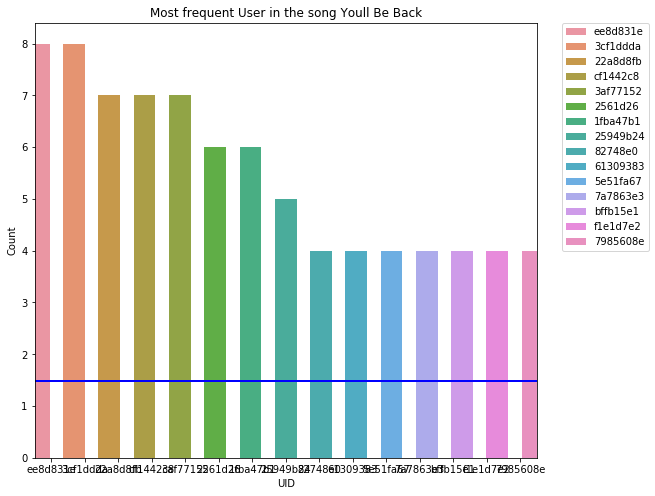

In [47]:
# Plot the most frequent uid 

plt.figure(figsize = (9, 8))
plt.title('Most frequent User in the song Youll Be Back')
sns.set_color_codes("pastel")
ax = sns.barplot(x="UID", y="Count", data=top_15,
            hue="UID")
plt.legend()

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
        
change_width(ax, .65)
count = youll_be_back['UID'].value_counts()
ave = count.sum()/len(youll_be_back['UID'].unique())

ax.axhline(ave, color='blue', linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


plt.show()

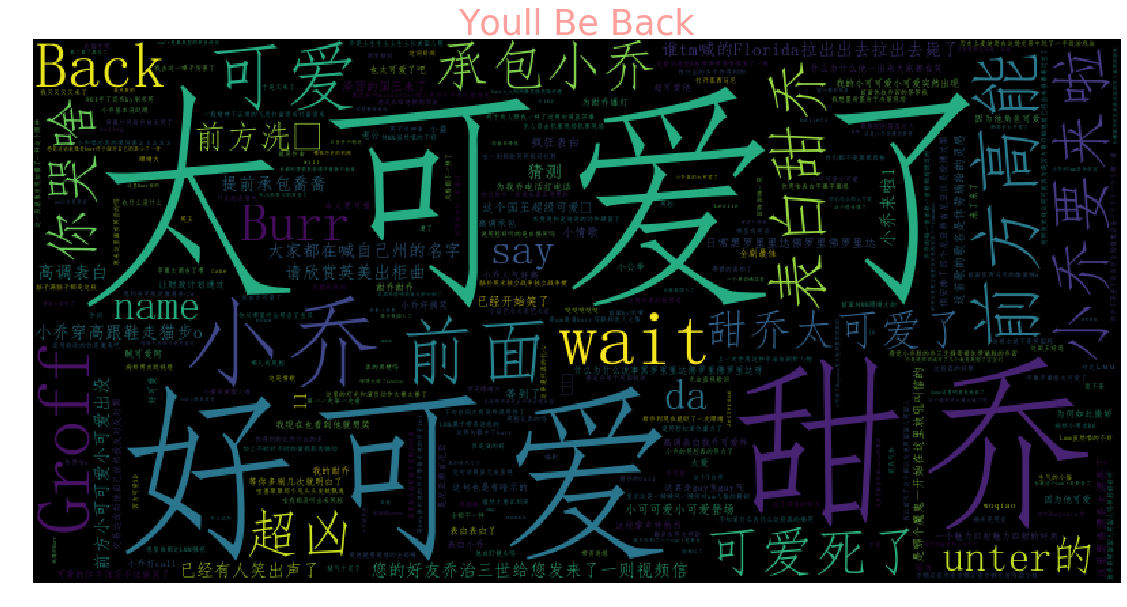

In [48]:
# prepare the word cloud
word = youll_be_back['Comment'] #subset barrage
word = [x for x in word] #list of the barrage
wl = " ".join(word) #joint together

#wl.rstrip('…】123.!?!！ \n\t')
wl = wl.strip('233!!!123456789.!...?！！！ \n\t')  #strip the special number
wl = wl.replace('ww','').replace('A','').replace('h','').replace('aa','') # replace letter with white space
wl = wl.replace('哈','').replace('啊','') # replace non meanning words eg, ha, A by chinese
wl = wl.replace('！','').replace('!','').replace('？','') # replace special words
wl = wl.replace('2','').replace('3','') # replace the 23333
wl

# word cloud
import jieba 
# "Jieba" (Chinese for "to stutter") Chinese text segmentation: built to be the best Python Chinese word segmentation module.

jieba = jieba.lcut_for_search(wl)  # search engines model: searchable word, return to the list
words = "".join(jieba)

# # Download simfang.ttf which is Chinese charactor 
# # from https://github.com/linuxdeepin-packages/ttf-simfang/blob/master/usr/share/fonts/truetype/sim/simfang.ttf
font = r'C:\Users\jolie\Downloads\simfang.ttf'  # Chinese font dir 
stopwords =STOPWORDS
# stopwords =('啊','哈哈','哈') # the chinese stopword doesn't work, so I just use replace and strip to clean the text
wc = WordCloud(font_path=font,
               background_color = "black", 
               max_words = 2000, # max word showed
               stopwords = stopwords, # stopwords for english
               width=800, # pic width
               height=400,
               margin = 2,# pic height
    )
myword = wc.generate(words)  #generate word cloud
 
# show the word cloud
plt.figure( figsize=(20,10) ) # figure size
plt.imshow(myword)  # plt
plt.title('Youll Be Back',fontsize=35,color='r')

plt.axis("off")
plt.show()
# myword.to_file("wordcloud.png")  # download 

## Analyze the comments for the different comment type

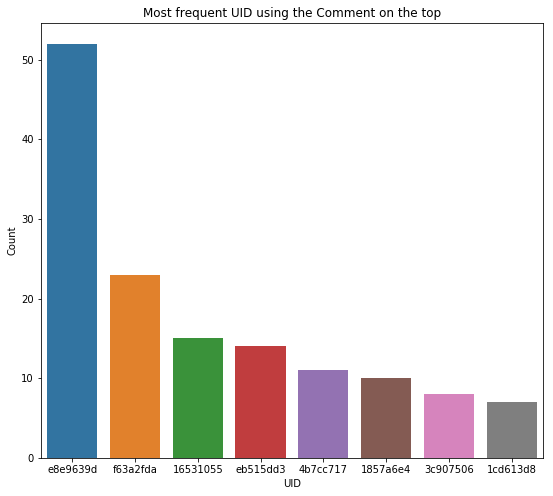

In [50]:
# type
table['Type'].value_counts()
# 1    6392      # type1 is Comment running on the top
# 5     342      # type5 is Comment on the top (not running)
# 4       9      # type4 is Comment on the bottom (not running)

# what they say for the barrage on the top 
ty = table[table['Type'] =='5'] 
county = ty['UID'].value_counts()

top_5 = county.head(8).reset_index()
top_5 = top_5.rename(columns = {top_5.columns[0]:"UID",top_5.columns[1]:"Count"})
# table[table['UID'] == 'e8e9639d'] 

# Plot the most frequent uid comment
plt.figure(figsize = (9, 8))
plt.title('Most frequent UID using the Comment on the top')
sns.set_color_codes("pastel")
sns.barplot(x="UID", y="Count", data=top_5,
            label="Count")
plt.show()

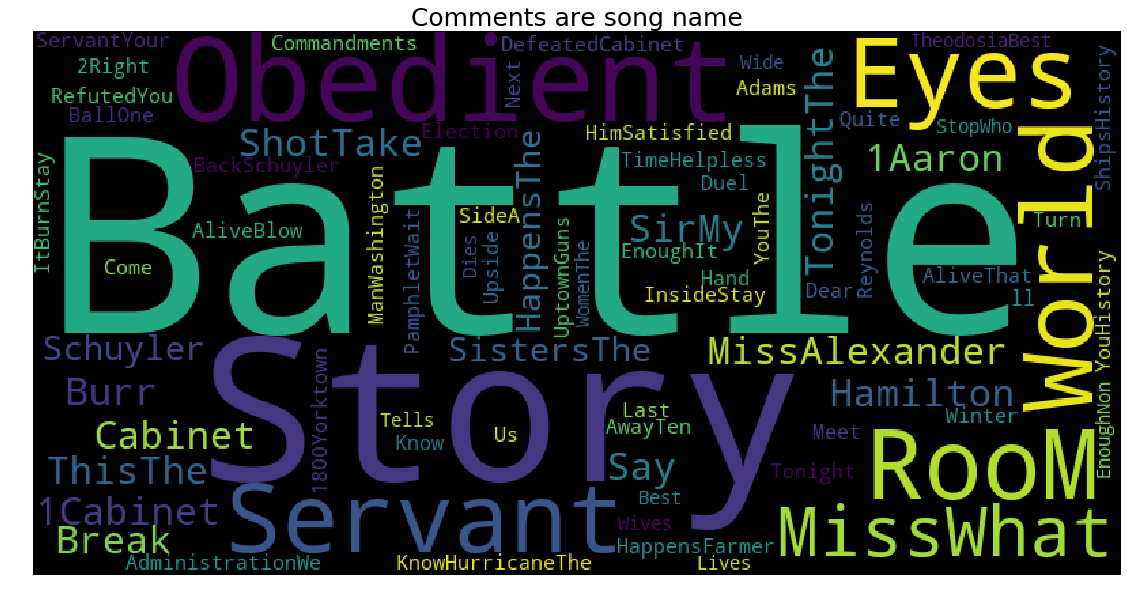

In [51]:
# what highest comment did say?
comment = ty[ty['UID'] == top_5["UID"][0]]['Comment']
words = "".join(comment)
# wc = WordCloud(prefer_horizontal = 0.8,
#                regexp = r"\w[\w']+",
#                normalize_plurals = True,
#                collocations = False,
#                #font_path=font,
#                background_color = "black", 
#                max_words = 2000, # max word showed
#                width=800, # pic width
#                height=400, # pic height
#     )
# myword = wc.generate(words)  #generate word cloud
 
# # show the word cloud
# plt.figure( figsize=(20,10) ) # figure size
# plt.imshow(myword)  # plt
# plt.axis("off")
# plt.show()

stopwords =STOPWORDS
wc = WordCloud(background_color = "black", 
               max_words = 2000, # max word showed
               stopwords = stopwords, # stopwords for english
               width=800, # pic width
               height=400, # pic height
               margin=2,
    )
myword = wc.generate(words)  #generate word cloud
 
# show the word cloud
plt.figure( figsize=(20,10) ) # figure size

plt.imshow(myword)  # plt
plt.title('Comments are song name',fontsize=25,color='black')

plt.axis("off")
plt.show()
# myword.to_file("song names.png")  # download 

# basiclly it just the song names

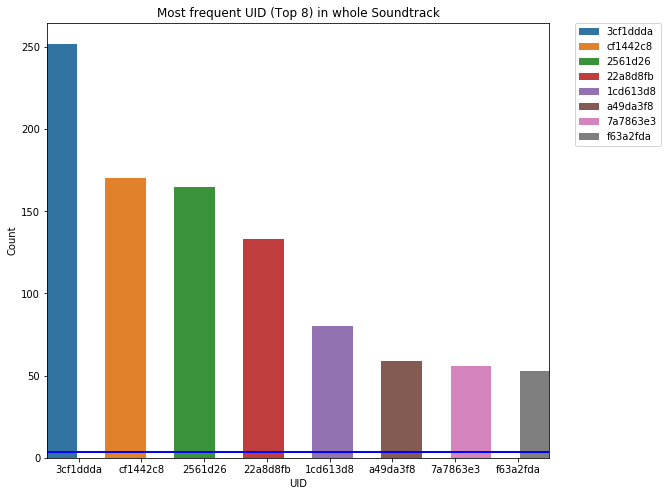

In [54]:
# who comment the most? 
UID = table['UID'].value_counts()

# top 8 
top_8 = UID.head(8).reset_index()
top_8= top_8.rename(columns = {top_8.columns[0]:"UID",top_8.columns[1]:"Count"})
# table[table['UID'] == 'e8e9639d'] 

# Plot the most frequent uid comment
plt.figure(figsize = (9, 8))
plt.title('Most frequent UID (Top 8) in whole Soundtrack')
sns.set_color_codes("pastel")
ax = sns.barplot(x="UID", y="Count", data=top_8,
            hue="UID")
plt.legend()

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
        
change_width(ax, .65)
ave = UID.sum()/len(table['UID'].unique())  #average comment number is 3.8

ax.axhline(ave, color='blue', linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

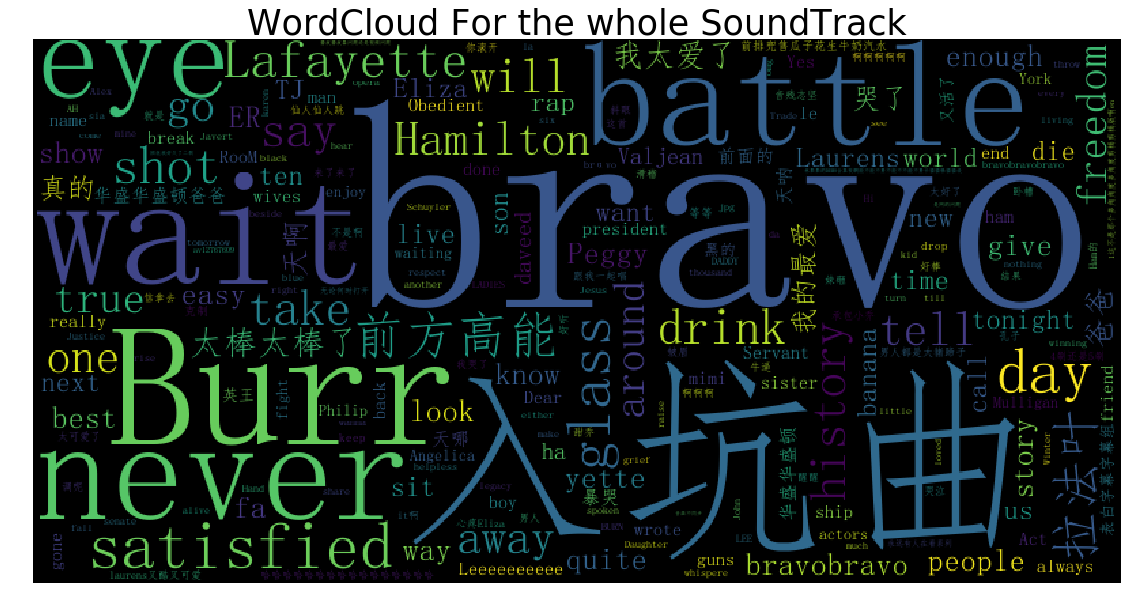

In [56]:
# word cloud for the the comment 
import jieba 
# "Jieba" (Chinese for "to stutter") Chinese text segmentation: built to be the best Python Chinese word segmentation module.
 

comment = [x for x in table['Comment']]
words = "".join(comment)


jieba = jieba.lcut_for_search(words)  # search engines model: searchable in search engines, return to the list
words = "".join(jieba)
stopwords = STOPWORDS

# Download simfang.ttf which is Chinese charactor 
# from https://github.com/linuxdeepin-packages/ttf-simfang/blob/master/usr/share/fonts/truetype/sim/simfang.ttf

font = r'C:\Users\jolie\Downloads\simfang.ttf'  # Chinese font dir 
wc = WordCloud(font_path=font,
               collocations=False,
               background_color = "black", 
               max_words = 2000, # max word showed
               stopwords = stopwords, # stop word
               width=800, # pic width
               height=400, # pic height
    )
myword = wc.generate(words)  #generate word cloud
 
# show the word cloud
plt.figure( figsize=(20,10) ) # figure size
plt.title('WordCloud For the whole SoundTrack',fontsize=35,color='Black')

plt.imshow(myword)  # plt
plt.axis("off")
plt.show()
# myword.to_file("comment.png")  # download 

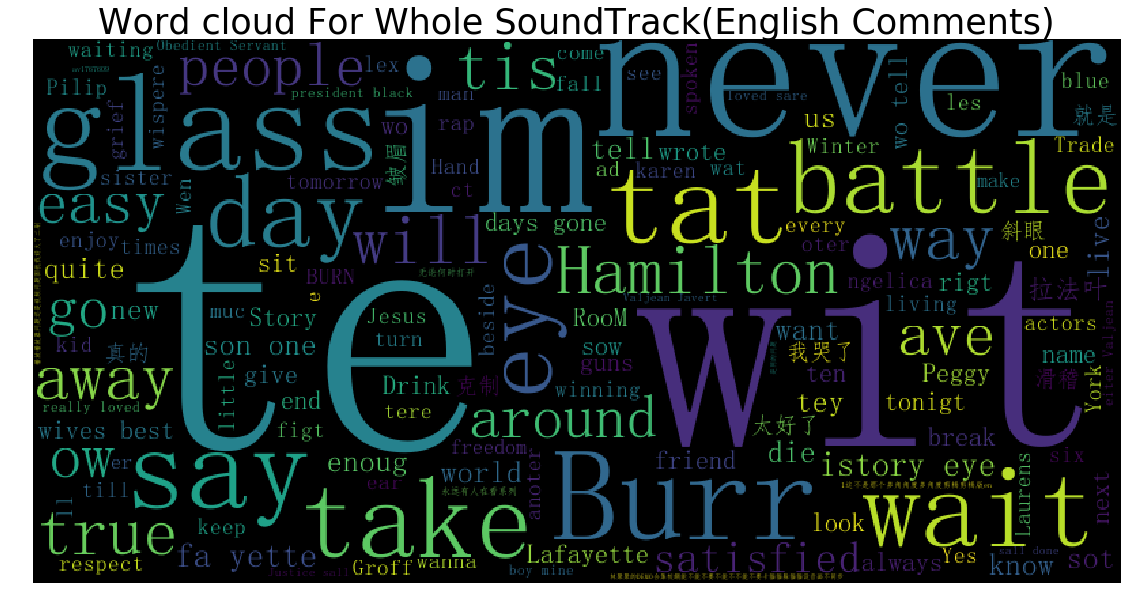

In [58]:
# prepare the word cloud
comment = [x for x in table['Comment']] # list of the barrage
words = "".join(comment)


words.rstrip('…】123.!?!！ \n\t')
words = words.strip('233!!!123456789.!...?！！！ \n\t')  #strip the special number
words = words.replace('ww','').replace('A','').replace('h','').replace('aa','') # replace letter with white space
words = words.replace('哈','').replace('啊','') # replace non meanning words eg, ha, A by chinese
words = words.replace('！','').replace('!','').replace('？','').replace('…','').replace('?','').replace('—','').replace('。','').replace('.','')# replace special words
words = words.replace('2','').replace('3','') # replace the 23333
words

# word cloud
import jieba 
# "Jieba" (Chinese for "to stutter") Chinese text segmentation: built to be the best Python Chinese word segmentation module.

jieba = jieba.lcut_for_search(words)  # search engines model: searchable word, return to the list
wd = "".join(jieba)

# # Download simfang.ttf which is Chinese charactor 
# # from https://github.com/linuxdeepin-packages/ttf-simfang/blob/master/usr/share/fonts/truetype/sim/simfang.ttf

font = r'C:\Users\jolie\Downloads\simfang.ttf'  # Chinese font dir 
#stopwords =STOPWORDS
# stopwords =('啊','哈哈','哈') # the chinese stopword doesn't work, so I just use replace and strip to clean the text
wc = WordCloud(font_path=font,
               background_color = "black", 
               max_words = 2000, # max word showed
             # stopwords = stopwords, # stopwords for english
               width=800, # pic width
               height=400, # pic height
    )
myword = wc.generate(wd)  #generate word cloud
 
# show the word cloud
plt.figure( figsize=(20,10) ) # figure size
plt.imshow(myword)  # plt
plt.title('Word cloud For Whole SoundTrack(English Comments)',fontsize=35,color='Black')

plt.axis("off")
plt.show()
myword.to_file("Comment.png")  # download 

In [44]:
# time
import matplotlib.pyplot 

# dates = matplotlib.dates.date2num("comment time")
# matplotlib.pyplot.plot_date(dates, table['comment'])
# len(table['comment time'].unique())

# len(table['comment'].value_counts())

In [59]:

table['Date'] = pd.to_datetime(table['Date'])
times = table.sort_values(by=['Date'])
# time[time['comment time']=='2016-05-27 08:00:47']
times.reset_index()
times = times[['Date','UID']]
times['value'] = "1" 
times = times.set_index('Date')
times = times.drop(columns=['UID'])

times['value'] = times['value'].astype(str).astype(int)
freq = times.resample('D', level=0).sum()
freq = freq.reset_index()

freq.head()

,Date,value
0,2017-10-03,2
1,2017-10-04,0
2,2017-10-05,1
3,2017-10-06,5
4,2017-10-07,4


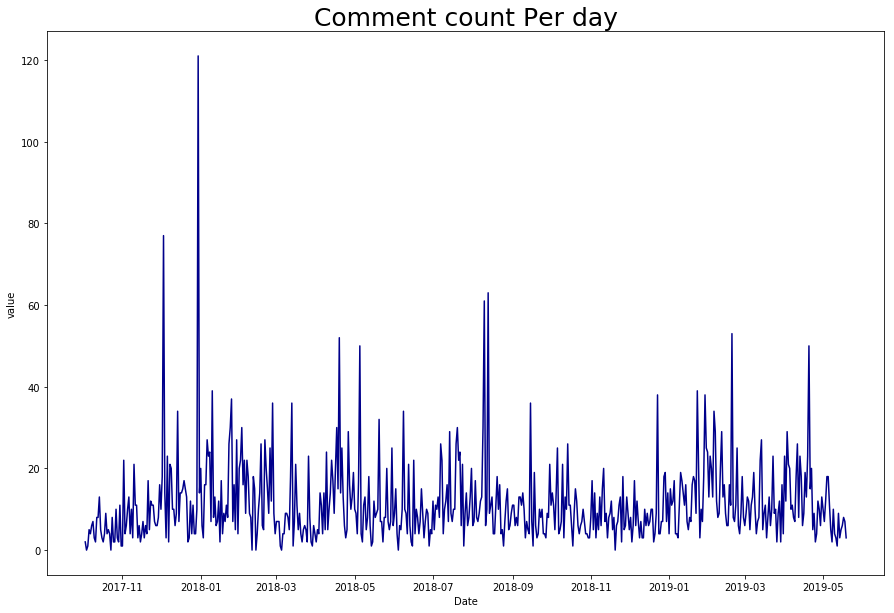

In [41]:
# type(time['value'])
# time['value'].dtypes

x = freq['Date']
y = freq['value']
plt.subplots(figsize=(15,10))
plt.title('Comment count Per day', fontsize = 25)
sns.lineplot(x,y,color="darkblue",data = freq)

In [60]:
table['Time'] = pd.to_datetime(table['Time'])
tm = table.sort_values(by=['Time'])
# time[time['comment time']=='2016-05-27 08:00:47']
tm.reset_index()
tm = tm[['Time','UID']]
tm['value'] = "1" 
tm = tm.set_index('Time')
tm = tm.drop(columns=['UID'])
tm['value'] = tm['value'].astype(str).astype(int)
freqtm = tm.resample('1t', level=0).sum()
freqtm = freqtm.reset_index()

freqtm.head()

,Time,value
0,2019-05-31 00:00:00,156
1,2019-05-31 00:01:00,106
2,2019-05-31 00:02:00,93
3,2019-05-31 00:03:00,71
4,2019-05-31 00:04:00,103


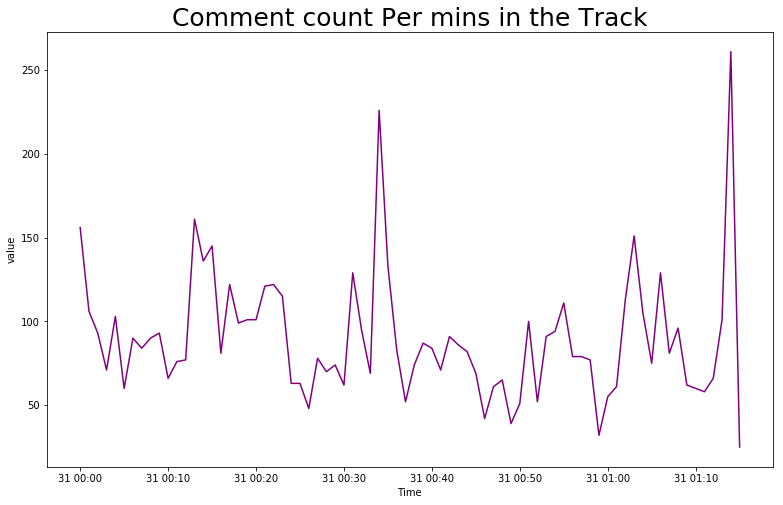

In [61]:
x = freqtm['Time']
y = freqtm['value']
plt.subplots(figsize=(13,8))
plt.title('Comment count Per mins in the Track', fontsize = 25)
sns.lineplot(x,y,color="purple",data = freqtm)